What is an ARIMA Model? 

ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). We will be implementing the ADCF test. 

ADCF Test - Augmented Dickey–Fuller test is used to gives us various values that can help in identifying stationarity. The Null hypothesis says that a TS is non-stationary. It comprises of a Test Statistics & some critical values for some confidence levels. If the Test statistics is less than the critical values, we can reject the null hypothesis & say that the series is stationary. THE ADCF test also gives us a p-value. Acc to the null hypothesis, lower values of p is better.

Import the relevant libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell 
import datetime as dt 
from datetime import timedelta
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pyplot as plt #for visualization
import matplotlib.dates as mdates
import seaborn as sns 
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline    
sns.set_theme(style="ticks", context="talk", palette="flare")   
plt.style.use("dark_background")

#ARIMA essentials
from scipy import stats 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
# add font types AVOID 
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
vig_origin = pd.read_csv('VIG.csv')
vig = vig_origin.copy() # deep_copy = True 

Create a checkpoint to revert to

Dataframe Visualisation

In [4]:
print(color.BOLD + "VIG DATASET" + color.END) 
vig.head() 


VIG DATASET


,Date,Open,High,Low,Close,Adj Close,Volume,%(close),AVE %
0,1/1/2007,54.230000,54.759998,53.450001,54.639999,39.334740,727800,-0.017387,-0.006088
1,1/2/2007,54.770000,55.720001,53.459999,53.689999,38.650837,397600,-0.000559,NaN
2,1/3/2007,52.900002,54.549999,51.900002,53.660000,38.629242,361000,0.044353,NaN
3,1/4/2007,53.750000,56.299999,53.480000,56.040001,40.479282,309500,0.024804,NaN
4,1/5/2007,55.849998,57.529999,55.730000,57.430000,41.483315,259200,-0.019328,NaN


Remove unimportant features except % (percentage) close per month <br>
Data Engineering, Check for Missing Values!

In [5]:
def exclude_rename_adjust(df): 
    exclude = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'AVE %']
    df = df.drop(columns = exclude) 
    df = df.set_index('Date')
    df = df.rename(columns = {"%(close)": "Price Movement(%)"}) # proper naming
    df['Price Movement(%)'] = df['Price Movement(%)'].apply(lambda x: x*100) # adjust for percentage
    return df

print(color.BOLD + "VIG DATASET" + color.END) 
vig = exclude_rename_adjust(vig) 
vig.head(3)
print("Any missing values? ")
print(vig.isnull().values.any())     



VIG DATASET
Any missing values? 
True


The ARIMA has 3 hyperparameters - P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA (Moving Average) part is used. The I part binds together the AR & MA parts. To figure out the value of P (auto regressive lags) and Q (moving avr), we require the help of ACF (auto correlation function) and PACF (partial auto correlation) plots. 

Exponential Smoothing: 

Rule of thumb technique for smoothing time series data using exponential window function. Whereas in the simple moving average the past observations are weighted equally, exponential functions are used to assign exponentially decreasing weights over time. It is an easily learned and easily applied procedure for making some determination based on prior assumptions by the user, such as seasonality. Exponential smoothing is often used for analysis of time-series data.

Now, we check for stationarity of our data with a simple plot. <br>
We notice that the final values of each dataset has a price movement of -100%, hence we omit these rows to allow for better visualisation. 

In [6]:
vig[vig['Price Movement(%)']==-100]
vig = vig.iloc[:-1:]


In [7]:
vig[vig['Price Movement(%)']==-100]

,Price Movement(%)
Date,


In [8]:
from matplotlib.dates import DateFormatter

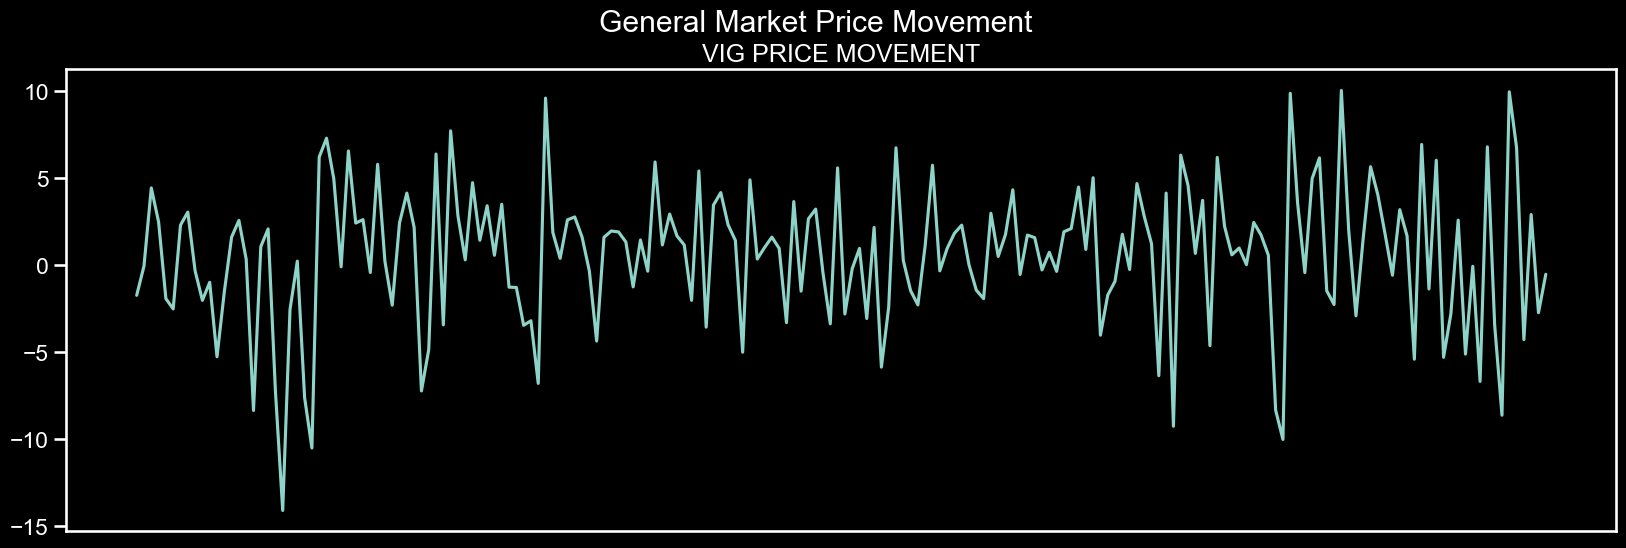

In [9]:
# plot graph
n_plots = 1

fig, axs = plt.subplots(n_plots, figsize=(20,6))

date_form = DateFormatter("%Y")

axs.plot(vig["Price Movement(%)"])
axs.set_title("VIG PRICE MOVEMENT")
axs.xaxis.set_major_formatter(date_form)

fig.suptitle("General Market Price Movement")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()


Stationarity Check - Perform ADCF Test

In [10]:
# ADF Test
result = adfuller(vig.values, autolag='AIC')

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -5.881584
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject Ho - Time Series is Stationary


In [11]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(vig['Price Movement(%)'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -5.881584e+00
p-value                        3.069403e-07
#Lags Used                     5.000000e+00
Number of Observations Used    1.880000e+02
Critical Value (1%)           -3.465620e+00
Critical Value (5%)           -2.877040e+00
Critical Value (10%)          -2.575032e+00
dtype: float64


For a Time series to be stationary, its ADCF test should have:

1. p-value to be low (according to the null hypothesis) <br>
2. The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics <br>

Hence, referencing from point 1, we can safely say that our Time Series is stationary. <br>
We do not need to perform Data Transformation or Differentiation to achieve Stationarity.

Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots

c:\Users\marcu\OneDrive\Desktop\JPM Hac\.venv\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1500x700 with 0 Axes>

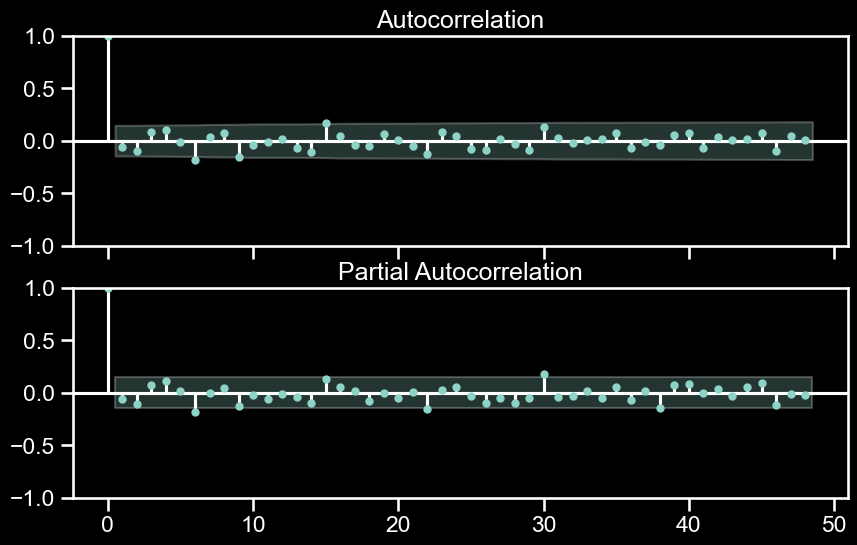

In [12]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
fig, ax = plt.subplots(2, sharex=True, sharey=True)
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(vig['Price Movement(%)'][13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(vig['Price Movement(%)'][13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Approximation of Parameters and Building our Model <br>
We use the Akaike information criterion (AIC) is a mathematical method for evaluating how well a model fits the data it was generated from.

In [13]:
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(vig['Price Movement(%)'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [15]:
print("Best Models")
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

Best Models
      parameters          aic
7   (0, 1, 0, 1)  1062.784524
13  (0, 2, 0, 1)  1064.482819
25  (1, 1, 0, 1)  1064.512377
9   (0, 1, 1, 1)  1064.673305
31  (1, 2, 0, 1)  1064.980789
                                     SARIMAX Results                                      
Dep. Variable:                  Price Movement(%)   No. Observations:                  194
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -528.392
Date:                            Wed, 22 Mar 2023   AIC                           1062.785
Time:                                    20:42:59   BIC                           1072.380
Sample:                                         0   HQIC                          1066.675
                                            - 194                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-

Analysis of Residues

Dickey–Fuller test:: p=0.000000


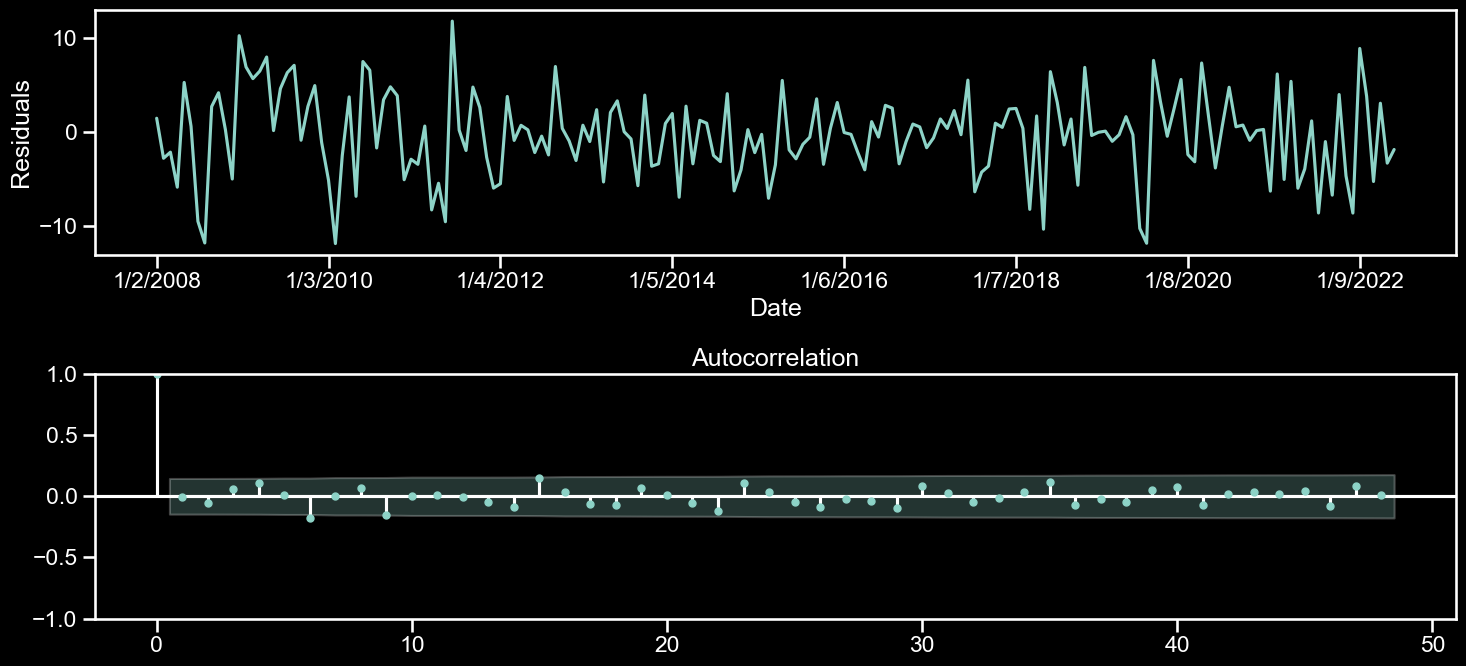

In [16]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

Test Prediction: 2015 to 2023

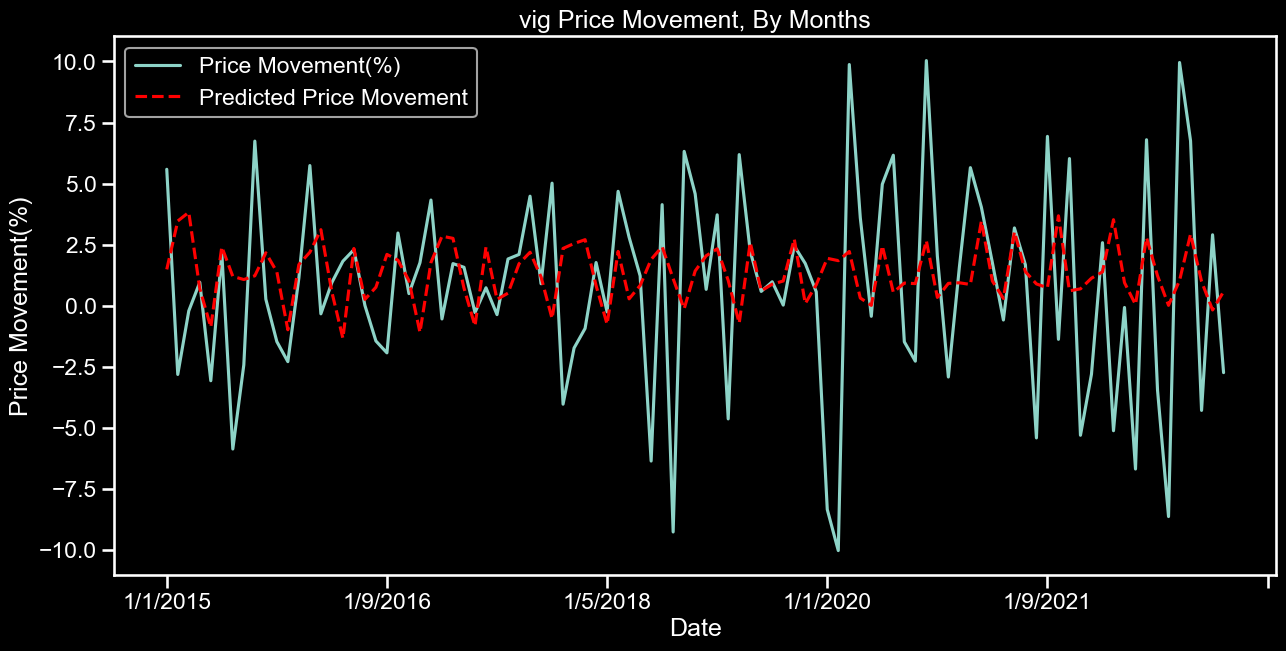

In [17]:
# Prediction
vig_test = vig.loc['1/1/2015':'1/1/2023']
vig_test['forecast'] = best_model.predict()
plt.figure(figsize=(15,7))
vig_test['Price Movement(%)'].plot()
vig_test['forecast'].plot(color='r', ls='--', label='Predicted Price Movement')
plt.legend()
plt.title('vig Price Movement, By Months')
plt.ylabel('Price Movement(%)')
plt.show()

A Step into the Future: 10 Year Prediction from 2023 to 2033 

In [18]:
vig.shape[0]

194

In [19]:
# format: 1/3/2023 DAY/MONTH/YEAR to be converted into a datetime object 
startdate = dt.date(int(2023), int(3), int(1))

date_list = [] # concatenate at the bottom of the vig dataset 
while startdate < dt.date(int(2033), int(3), int(1)):
    startdate += timedelta(days=31)
    formatted_date = startdate.strftime("%d-%m-%Y")
    date_list.append(formatted_date) 
print(date_list)
future = len(date_list) 

['01-04-2023', '02-05-2023', '02-06-2023', '03-07-2023', '03-08-2023', '03-09-2023', '04-10-2023', '04-11-2023', '05-12-2023', '05-01-2024', '05-02-2024', '07-03-2024', '07-04-2024', '08-05-2024', '08-06-2024', '09-07-2024', '09-08-2024', '09-09-2024', '10-10-2024', '10-11-2024', '11-12-2024', '11-01-2025', '11-02-2025', '14-03-2025', '14-04-2025', '15-05-2025', '15-06-2025', '16-07-2025', '16-08-2025', '16-09-2025', '17-10-2025', '17-11-2025', '18-12-2025', '18-01-2026', '18-02-2026', '21-03-2026', '21-04-2026', '22-05-2026', '22-06-2026', '23-07-2026', '23-08-2026', '23-09-2026', '24-10-2026', '24-11-2026', '25-12-2026', '25-01-2027', '25-02-2027', '28-03-2027', '28-04-2027', '29-05-2027', '29-06-2027', '30-07-2027', '30-08-2027', '30-09-2027', '31-10-2027', '01-12-2027', '01-01-2028', '01-02-2028', '03-03-2028', '03-04-2028', '04-05-2028', '04-06-2028', '05-07-2028', '05-08-2028', '05-09-2028', '06-10-2028', '06-11-2028', '07-12-2028', '07-01-2029', '07-02-2029', '10-03-2029', '10-0

In [20]:
export = best_model.forecast(steps=future)

In [21]:
export.to_csv(r'VIG_PriceXTime', index=True, header=True)